In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from decomposer import Decomposer
from scipy.optimize import minimize

from warnings import simplefilter
simplefilter('ignore')

In [2]:
df = pd.read_csv('gdp.csv', sep=';')
branches = ['Cp', 'Gp', 'Jp', 'Exp', 'Imp']

In [3]:
decomposer = Decomposer(df, branches, n_components=3)  # инициализировать модель
decomposer.fit(multistarts=15, reg=0.1)  # обучить модель с регуляризацией, сделать 10 мультистартов и выбрать лучший
decomposer.fit(multistarts=1, reg=0, x0=decomposer)  # обучить модель без регуляризации, инициализируя текущими значениями

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

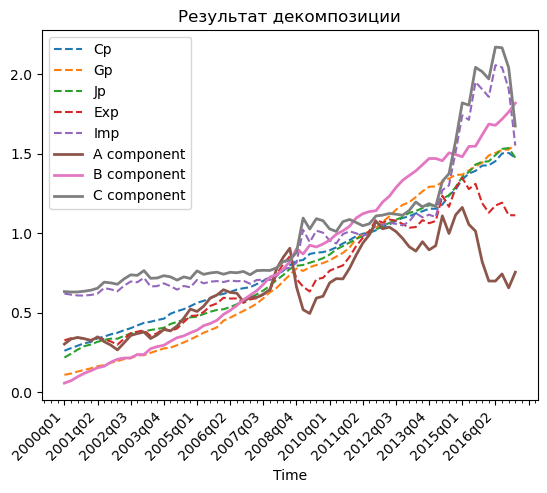

In [4]:
ax = df[branches].plot(linestyle='--')
sns.lineplot(x=df.t, y=decomposer.first_component,  label='A component',
             linewidth=2, ax=ax)
sns.lineplot(x=df.t, y=decomposer.second_component,  label='B component',
             linewidth=2, ax=ax)
if len(decomposer.components) > 2:
    sns.lineplot(x=df.t, y=decomposer.third_component,  label='C component', linewidth=2, ax=ax)
if len(decomposer.components) > 3: 
    sns.lineplot(x=df.t, y=decomposer.components[3],  label='D component', linewidth=2, ax=ax)
if len(decomposer.components) > 4:
    sns.lineplot(x=df.t, y=decomposer.components[4],  label='E component', linewidth=2, ax=ax)
ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Time")
plt.title("Результат декомпозиции"); 
ax.figure.savefig('components.png', dpi=250)  # раскомментируйте, если хотите сохранить картинку

In [5]:
"""Вывод результатов разложения (alpha, rho)"""
decomposer.summary('ces').round(4)

,Cp,Gp,Jp,Exp,Imp
alpha_0,0.2535,0.0288,0.1820,0.5712,0.0000
alpha_1,0.4211,0.9392,0.5658,0.2909,0.0000
alpha_2,0.3254,0.0320,0.2522,0.1379,1.0000
rho,5.3247,7.0640,6.6054,4.7867,6.1919


In [6]:
"""Вывод метрик"""
decomposer.summary('errors').round(4)

,Cp,Gp,Jp,Exp,Imp
MSE,0.0014,0.0003,0.0003,0.0004,0.0002
MAPE,0.0483,0.0285,0.0196,0.0247,0.0113
MAE,0.0314,0.0133,0.0121,0.0153,0.0099


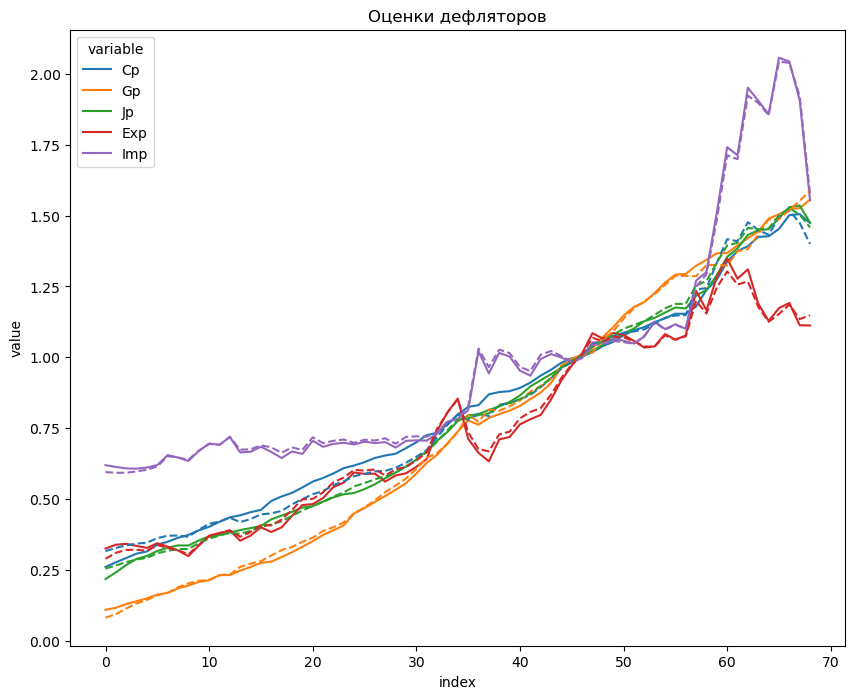

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(pd.melt(decomposer.targets.reset_index(), id_vars='index'), x='index', y='value', hue='variable')
sns.lineplot(pd.melt(decomposer.predictions.reset_index(), id_vars='index'),
             x='index', y='value', hue='variable', linestyle='--', legend=False)
plt.title("Оценки дефляторов")
ax.figure.savefig('preds.png', dpi=250)  # раскомментируйте, если хотите сохранить картинку

In [8]:
decomposer.save()
alpha, rho, components, base_coeffs, targets = [v for k, v in np.load('res.npz').items()]

### Попытка оценки объёмов компонент ВВП

In [9]:
X = df[[i[:-1] for i in decomposer.branches]].to_numpy()


def target(base_x):
    total_loss = 0
    res = decomposer.estimate_x(X, base_x)
    for k, branch in enumerate(branches):
        total_loss += np.sum((df[branch[:-1]] - res[:, k].T.sum(axis=1))**2)
    return total_loss


good_base_x = minimize(target, np.ones(3), bounds=[(1e-5, 10) for _ in range(3)]).x

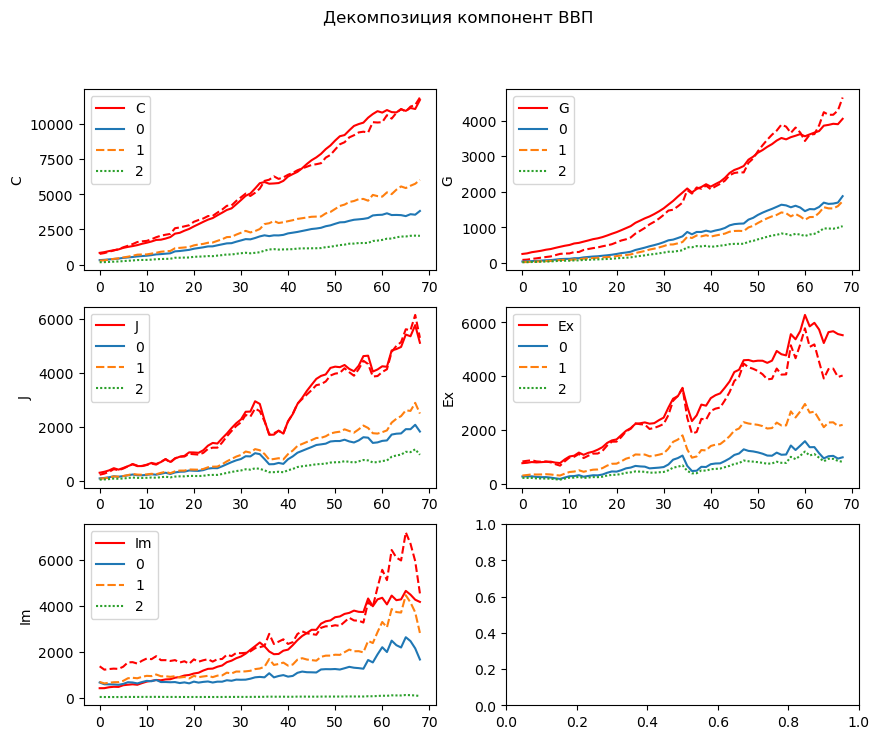

In [10]:
"""Вроде бы пока что работает не совсем праильно"""
X = df[[i[:-1] for i in decomposer.branches]].to_numpy()
res = decomposer.estimate_x(X, good_base_x)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
for k, branch in enumerate(branches):
    i, j = np.divmod(k, 2)
    sns.lineplot(df[branch[:-1]], ax=ax[i, j], color='red', label=branch[:-1])
    sns.lineplot(res[:, k].T.sum(axis=1), ax=ax[i, j], color='red', linestyle='--')
    sns.lineplot(res[:, k].T , ax=ax[i, j], linestyle='--')
plt.suptitle("Декомпозиция компонент ВВП");